In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 

#import rdata

In [66]:
#parsed = rdata.parser.parse_file('CNSIM1.rda')
#converted = rdata.conversion.convert(parsed)
#df = converted['CNSIM1']
#df.to_csv('CNSIM1.csv')
df = pd.read_csv('CNSIM1.csv', index_col=0)

In [67]:
k = 0
sample_size_max = df.shape[0]
n_variables = df.shape[1]
print('number of samples:', sample_size_max)

number of samples: 2163


In [68]:
def sampleCov(x, y):
    """compute sample covariance"""
    return 1. / (x.size - 1) * np.dot(x,y) - x.size / (x.size - 1) * np.mean(x) * np.mean(y)

In [69]:
def rmse(x_estimate, x_true, R):
    """
    Args:
        x_estimate: np.array; estimated variable
        x_true: np.array; true variable
        R: int; number of already performed iterations

    Returns: float; residual mean squared error

    """
    error_sum = 1./R * np.sum(x_estimate - x_true)
    nominator = np.linalg.norm(error_sum)**2
    denominator = np.linalg.norm(x_true) ** 2
    rmse = nominator / denominator
    return rmse

In [70]:
def covariance_based_attack_algorithm(data, k, R=1, noise_levels=None, progress_bar=False):
    """
    Args:
        data: np.array; list of servers, each server is a list of variables
        k: int; which variable to steal
        R: int; number of iterations
        noise_levels: np.array (optional); noise levels for each server (gamma, epsilon)
        progress_bar: bool; whether to show the progress bar

    Returns: np.array; errors for each server after every iteration

    """
    if R == 0:
        return np.array([np.Inf])
    
    # get data
    X_jk = data[:, k]
    X_jk = X_jk[~(np.isnan(X_jk))]
    n_j = X_jk.size
    
    # create placeholders
    X_stolen = np.zeros((R, n_j))
    error = np.zeros(R)
    
    if noise_levels is not None:
        noise_gamma = noise_levels[0]
        noise_epsilon = noise_levels[1]
    
    # on client side
    # mean, and covariance performed on server, just return solutions
    for r in tqdm(range(R), disable=not progress_bar):
    
        # create linearly independent vectors
        Y = np.eye(n_j)

        # initialise V, m 
        V = np.zeros(n_j)
        m = np.zeros(n_j)

        # compute sample means and covariances
        for i in range(n_j):
            m[i] = np.mean(Y[i, :]) # on client
            V[i] = sampleCov(X_jk, Y[i, :]) # function on server

        X_jk_mean = np.mean(X_jk) # function on server

        # add noise to data
        if noise_levels is not None:
            X_jk_mean += np.random.normal(0, scale=np.sqrt(noise_gamma)) # one dimensional random variable
        if noise_levels is not None:
            V += np.random.multivariate_normal(np.zeros(V.size),
                                               cov=np.eye(V.size)*np.sqrt(noise_epsilon)) # random vector

        # client side
        # compute inverse of Y
        Y_inv = np.linalg.inv(Y.T)
        # recover data on client side
        X_stolen[r, :n_j] = (n_j - 1) * np.matmul(Y_inv, V) + n_j * X_jk_mean * np.matmul(Y_inv, m)

        # average out the noise (if any)
        X_stolen_current = np.sum(X_stolen, axis=0) / (r+1)

        # compute error
        error[r] = rmse(X_stolen_current[:n_j], X_jk, r+1)
    return error            

In [71]:
k=0
error = covariance_based_attack_algorithm(data=df.values, k=k, R=1, noise_levels=[0.001, 0.001],
                                          progress_bar=True)

tol=1e-3
if error[-1] == 0:
    print('exact success')
elif error[-1] < tol:
    print('success')
    print('error below tolerance:', error[-1].round(5))
else:
    print('failed')
    print('error:', error[-1].round(5))

100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

failed
error: 28.5378


## Differential Privacy
$M(d)= f(d)+ \mathcal{N}(0, S_f^2 \cdot\sigma^2)$

sensitivity of the mean is $\frac{1}{n(n+1)} \vert \sum_{i=1}^n (m-x_i) \vert \leq \vert \frac{m}{n+1} \vert$ where $m = \arg\max_{x_i} \vert \bar{x}-x_i\vert$
(see https://programming-dp.com/ch7.html)

The sensitivity of sampleCov is estimated by first computing the true covariance $\operatorname{Cov}(x,y_i)$ for all independent vectors $y_i$ and data $x$.
Then, the maximum of $x$ is added to the vector $x$ and the covariance $\operatorname{Cov}(\hat{x},y_i)$ is computed.
Then the maximum absolute difference over $i$ is taken as the local sensitivity. 

a DP mechanism with a larger ε gives a clearer distinguishability of neighboring datasets and thus a higher risk of privacy violation

privacy parameter δ represents a “failure probability”: With probability δ, anything at all could happen - including a release of the entire sensitive dataset! 
For this reason, we typically require δ to be very small - usually $\frac1{n^2}$ or less.

sequential composition:
approximate differential privacy is additive



Add noise of level $\mathcal{N}(0, S_f^2 \cdot\hat{\sigma}^2)$, then it holds $(\epsilon,\delta)$-differential privacy with
$$\delta \geq \frac45 \exp\left(−\frac12(\hat{\sigma} \epsilon)^2\right).$$

Hence, with a noise of level $\mathcal{N}(0,\sigma^2)$ we get the lower bound
$$
    \epsilon^2 \geq \frac{2S_f^2 \log(1.25/\delta)}{\sigma^2}
$$

If we repeat an operation $n$ times and we want to achieve $(\epsilon,\delta)$-differential privacy, each operation needs to satisfy $(\frac{\epsilon}{n},\frac{\delta}{n})$-differential privacy, hence
$$
   \frac{\epsilon^2}{n^2}  \geq \frac{2S_f^2 \log(1.25\frac{n}{\delta})}{\sigma^2}
$$
and
$$
    \frac{\sigma^2\epsilon^2}{2S_f^2 \log(\frac{1.25}{\delta}) } \geq n^2 (1 +\log(n))
$$

For Huth's algorithm this means, if the mean-function is $(\epsilon_m,\delta_m)$-differential private,
the sampleCov must satisfy $(\frac{\epsilon-\epsilon_m}{n},\frac{\delta-\delta_m}{n})$-differential privacy
$$
   (\epsilon-\epsilon_m)^2  \geq \frac{2S_f^2n^2 \log(1.25\frac{n}{\delta-\delta_m})}{\sigma^2},
$$
where $n$ is the number of data points, i.e. the number of calls to sampleCov.

In [72]:
def get_epsilon_cov_based_attack(delta, sigma_mean_2, sigma_cov_2, S_f_2_mean, S_f_2_cov, n):
    """
        Calculate the minimal epsilon for a given privacy budget for the covariance based attack.
    """
    # the mean satisfies (e_m, delta/(n+1))-dp
    delta_mean = delta / (n+1)
    epsilon_mean = np.sqrt( 2 * S_f_2_mean * np.log(1.25 / delta_mean) / sigma_mean_2 )
     # the cov satisfies (e_cov, delta/(n+1))-dp
    epsilon_cov = np.sqrt( 2 * S_f_2_cov * n**2 * np.log(1.25 * n / (delta-delta_mean)) / sigma_cov_2 )
    # together they satisfy (epsilon,delta)-dp
    epsilon = epsilon_cov + epsilon_mean
    return epsilon, epsilon_mean, epsilon_cov

def get_number_evaluations(epsilon, delta, sigma_2, S_f_2):
    """
        Calculate the number of possible evaluations for the covariance based attack algorithm until privacy budget is consumed given
         epsilon, delta, sigma^2, and the sensitivity of the function f, which we want to apply.
    """
    div = 2 * S_f_2 * np.log(1.25 / delta)
    rhs = sigma_2 * (epsilon**2) / div
    
    find_n = lambda n: n**2 * (1 + np.log(n))
    
    n = 1
    while True:
        if find_n(n) > rhs:
            # equation does not hold, max n found
            n = n - 1
            break
        n += 1
        
    return n

In [73]:
def get_sensitivity_mean(x):
    """
    Get sensitivity of calculating the mean of a variable x
    Args:
        x: np.array; variable

    Returns: float; sensitivity

    """
    n = x.size
    mean = np.mean(x)
    arg_m = np.argmax(x-mean)
    m = x[arg_m]
    S_f_2_mean = np.abs((np.sum(x) + m)/(n+1) - np.mean(x))**2
    return S_f_2_mean

def get_sensitivity_var(x):
    """
    Get sensitivity of calculating the variance of a variable x
    Args:
        x: np.array; variable

    Returns: float; sensitivity

    """
    n = x.size
    var_x = np.var(x)
    
    var = np.zeros(n)
    for j, x_j in enumerate(x):
        x_2 = np.concatenate((x, [x_j]))
        var[j] = np.var(x_2)
        
    S_f_2_var = np.max(np.abs(var_x-var))**2
    return S_f_2_var

def get_sensitivity_cov_y(x):
    """
    Get sensitivity of calculating the covariance of a variable x with any unit vector
    Args:
        x: np.array; variable

    Returns: float; sensitivity

    """
    n = x.size
    
    V_1 = np.zeros(n)
    y = np.eye(n)
    for i in range(n):
        V_1[i] = sampleCov(x, y[i, :])
    
    S_f_2_cov_list = np.zeros(n)
    for j, x_j in enumerate(x):
        x_2 = np.concatenate((x, [x_j]))
        V_2 = np.zeros(n)
        y = np.eye(n+1)
        for i in range(n):
            V_2[i] = sampleCov(x_2, y[i, :])

        S_f_2_cov_list[j] = np.max(np.abs(V_1-V_2))**2
        
    S_f_2_cov = np.max(S_f_2_cov_list)    
    return S_f_2_cov

def get_sensitivity_cov(x, y):
    """
    Get sensitivity of calculating the covariance of a variable x with the variable y
    Args:
        x: np.array; variable

    Returns: float; sensitivity

    """
    V_1 = sampleCov(x, y)
    V_2 = np.zeros((x.size, y.size))
    for j, x_j in enumerate(x):
        #x_j = np.max(x) ##
        x_2 = np.concatenate((x, [x_j]))
        
        for i, y_i in enumerate(y):
            #y_i = np.max(y) ##
            y_2 = np.concatenate((y, [y_i]))
            V_2[j, i] = sampleCov(x_2, y_2)

    S_f_2_cov = np.max(np.abs(V_2-V_1))**2
    return S_f_2_cov

## Privacy Budget

$\delta = \frac{1}{n^2}$, different values for $\sigma$

In [74]:
# get data
X_jk = df.values[:, k]
X_jk = X_jk[~(np.isnan(X_jk))]
n_j = X_jk.size

# privacy budget
noise_levels = np.array([[0.01, 0.01], # noise on mean, noise on cov
                         [0.05, 0.05], 
                         [0.1, 0.1], 
                         [0.2, 0.2],
                         [0.25, 0.25],
                         [0.3, 0.3],
                         [0.3, 0.2]])
min_delta = 1./(n_j**2)

# get sensitivities
S_f_2_mean = get_sensitivity_mean(X_jk)
print('sensitivity mean:', S_f_2_mean)
S_f_2_cov = get_sensitivity_cov_y(X_jk)
print('sensitivity cov:', S_f_2_cov)

sensitivity mean: 5.7300034536659914e-06
sensitivity cov: 7.0271525745482405e-12


In [75]:
# get minimal epsilons for given noise level
epsilons = np.zeros(noise_levels.shape[0])    
for n, (nl_mean, nl_cov) in enumerate(noise_levels):
    
    epsilons[n], _,_ = get_epsilon_cov_based_attack(min_delta, sigma_mean_2=nl_mean, sigma_cov_2=nl_cov,
                                                    S_f_2_mean=S_f_2_mean, S_f_2_cov=S_f_2_cov, n=n_j)

In [76]:
noise_labels = []
for n_pair in noise_levels:
    label = f'$\sigma^2_m = {n_pair[0]}$, $\sigma^2_c = {n_pair[1]}$'
    noise_labels.append(label)

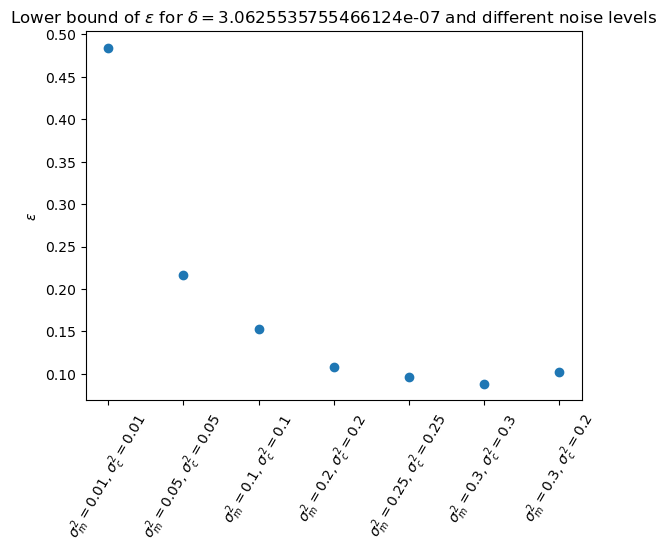

In [77]:
fig, ax = plt.subplots()
x_ticks = np.arange(0, len(noise_labels))
ax.scatter(x_ticks, epsilons)
ax.set_ylabel('$\epsilon$')
ax.set_xticks(x_ticks)
ax.set_xticklabels(noise_labels, rotation=60)
plt.title(f'Lower bound of $\epsilon$ for $\delta=${min_delta} and different noise levels')
#plt.legend()
plt.show()

## How often can we compute sampleCov and mean?

In [78]:
# privacy budget
noise_levels = np.array([0.01, 0.05, 0.1, 0.2, 0.25, 0.3]) #, 1, 10, 100, 1000])
epsilons = np.linspace(0, np.log(3), 100)

In [79]:
# get epsilons
cov_evaluations = np.zeros((noise_levels.shape[0], epsilons.shape[0])).astype(np.int64)
mean_evaluations = np.zeros((noise_levels.shape[0], epsilons.shape[0])).astype(np.int64)
for n, nl in enumerate(noise_levels):
    for e, eps in enumerate(epsilons):
        cov_evaluations[n, e] = get_number_evaluations(epsilon=eps, delta=min_delta,
                                                       sigma_2=nl, S_f_2=S_f_2_cov)
        mean_evaluations[n, e] = get_number_evaluations(epsilon=eps, delta=min_delta,
                                                       sigma_2=nl, S_f_2=S_f_2_mean)

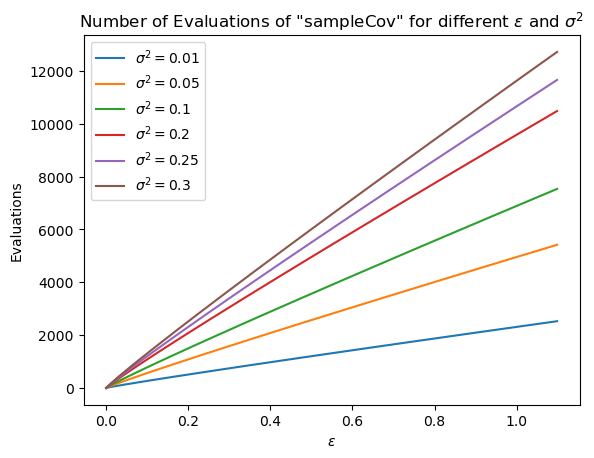

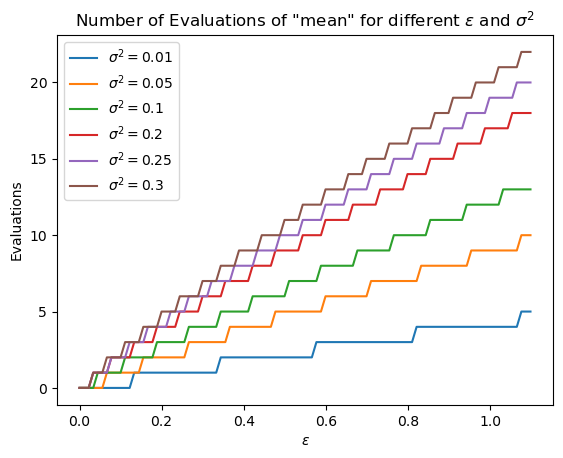

In [80]:
plt.figure()
for n, nl in enumerate(noise_levels):
    plt.plot(epsilons, cov_evaluations[n, :], label=f'$\sigma^2=${nl}')
plt.ylabel('Evaluations')
plt.xlabel('$\epsilon$')
plt.title(f'Number of Evaluations of "sampleCov" for different $\epsilon$ and $\sigma^2$')
plt.legend()
plt.show()

plt.figure()
for n, nl in enumerate(noise_levels):
    plt.plot(epsilons, mean_evaluations[n, :], label=f'$\sigma^2=${nl}')
plt.ylabel('Evaluations')
plt.xlabel('$\epsilon$')
plt.title(f'Number of Evaluations of "mean" for different $\epsilon$ and $\sigma^2$')
plt.legend()
plt.show()

## How often can we perform the algorithm and what is the error?

In [81]:
# get number of iterations of algorithm
R_max = 1000

n_iterations = np.zeros((epsilons.shape[0], noise_levels.shape[0])).astype(np.int64)
for n, nl in enumerate(noise_levels):
    for e, eps in enumerate(epsilons):
        # privacy budget for calculating mean
        for r in range(1, R_max+1):
            # test if r iterations are possible
            current_eps, _, _ = get_epsilon_cov_based_attack(min_delta / r, sigma_mean_2=nl, sigma_cov_2=nl,
                                                             S_f_2_mean=S_f_2_mean, S_f_2_cov=S_f_2_cov, n=n_j)
            current_r_eps = current_eps * r
            if current_r_eps > eps:
                break
            n_iterations[e, n] = r
            if r == R_max:
                print('R_max reached, try higher...')

In [82]:
df_iterations = pd.DataFrame(n_iterations, index=epsilons, columns=noise_levels)
#df_iterations.to_csv('n_iterations.csv')

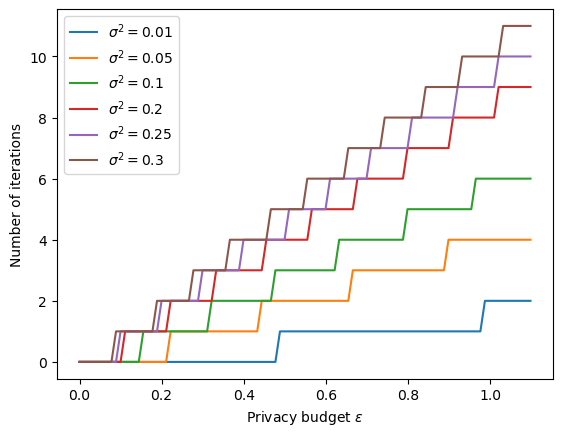

In [83]:
plt.figure()
for n, nl in enumerate(noise_levels):
    plt.plot(epsilons, n_iterations[:, n], label=f'$\sigma^2=${nl}')
plt.ylabel('Number of iterations')
plt.xlabel('Privacy budget $\epsilon$')
#plt.title(f"Number of Iterations of Huth's Algorithm for different $\epsilon$ and $\sigma^2$")
plt.legend()
#plt.savefig('plots/iter_huth_algo.png')
plt.show()

In [85]:
n_iter_for_median = 1
errors = np.zeros((n_iter_for_median, noise_levels.shape[0], epsilons.shape[0]))

for i_median in range(n_iter_for_median):
    print('\niteration:', i_median+1)
    for n, nl in enumerate(noise_levels):
        print('noise level:', nl)
        for e, eps in enumerate(epsilons):
            # perform algorithm to get error estimate
            errors[i_median, n, e] = covariance_based_attack_algorithm(data=df.values, k=k, R=n_iterations[e, n],
                                                                       noise_levels=[nl, nl],
                                                                       progress_bar=False)[-1] # only the last error is interesting

#np.save('errors.npy', errors)


iteration: 1
noise level: 0.01
noise level: 0.05


KeyboardInterrupt: 

In [86]:
job_array = np.arange(1,201,1) 
epsilons = np.linspace(0, 1, 100)
errors = np.zeros((job_array.size, noise_levels.shape[0], epsilons.shape[0]))
for i, task in enumerate(job_array):
    errors[i] = np.load(f'output/errors_{task}.npy')

In [87]:
median_error = np.median(errors, axis=0)
df_median_error = pd.DataFrame(median_error.T, index=epsilons, columns=noise_levels)
#df_median_error.to_csv('median_error.csv')

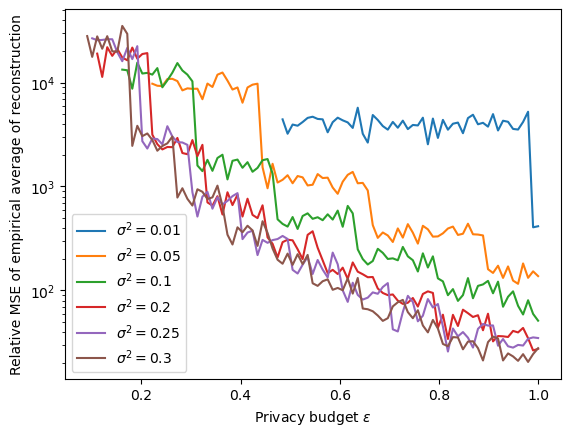

In [88]:
plt.figure()
for n, nl in enumerate(noise_levels):
    plt.plot(epsilons, median_error[n, :], label=f'$\sigma^2=${nl}')
plt.ylabel('Relative MSE of empirical average of reconstruction')
plt.xlabel('Privacy budget $\epsilon$')
plt.yscale('log')
#plt.ylim(0,1000)
#plt.title(f"Median of Huth's Algorithm for different $\epsilon$ and $\sigma^2$ ({n_iter_for_median} runs)")
plt.legend()
#plt.savefig('plots/error_huth_algo.png')
plt.show()

## Privacy Budget Consumption for "Normal Analysis"

Using two variables, calculate mean, var and covariance between them

In [304]:
# only look at the metric variables
df_metric = df[df.columns[:5]]
n_max = df_metric.values.shape[0]
n_vars = df_metric.values.T.shape[0]

# privacy budget
noise_levels = np.linspace(0.01, 0.3,100)
min_delta = 1./(n_max**2)

# variable 1 and 3
subset = [1,3]
n_operations = 2 + 2 + 1 # 2*mean + 2*var + 1*sampleCov

In [305]:
def get_epsilon(delta, sigma_2, S_f_2):
    """
     Calculate privacy budget for given delta, sigma^2, and sensitivity.
    """
    epsilon = np.sqrt( 2 * S_f_2 * np.log(1.25 / delta) / sigma_2 )
    return epsilon

In [306]:
def compute_epsilons_for_normal_analysis(df_metric, noise_levels, n_operations, subset):
    epsilons_mean = np.zeros((2, len(noise_levels)))
    var_k = 0
    for k, X_jk in enumerate(df_metric.values.T):
        if k not in subset:
            continue
        # take out NaN values
        X_jk_reduced = X_jk[~(np.isnan(X_jk))]
        # get sensitivity of the mean
        S_f_2_mean = get_sensitivity_mean(X_jk_reduced)
        # get privacy budget for computing the mean
        for i, nl in enumerate(noise_levels):
            epsilons_mean[var_k, i] += get_epsilon(min_delta / n_operations, nl, S_f_2_mean)
        var_k += 1

    epsilons_var = np.zeros((2, len(noise_levels)))
    var_k = 0
    for k, X_jk in enumerate(df_metric.values.T):
        if k not in subset:
            continue
        # take out NaN values
        X_jk_reduced = X_jk[~(np.isnan(X_jk))]
        # get sensitivity of the variance
        S_f_2_mean = get_sensitivity_var(X_jk_reduced)
        # get privacy budget for computing the variance
        for i, nl in enumerate(noise_levels):
            epsilons_var[var_k, i] += get_epsilon(min_delta / n_operations, nl, S_f_2_mean)
        var_k += 1


    epsilons_cov = np.zeros(len(noise_levels))
    X_jk = df_metric.values.T[subset[0]]
    X_jk2 = df_metric.values.T[subset[1]]

    non_nans = ~np.isnan(X_jk)*~np.isnan(X_jk2)
    X_jk_reduced = X_jk[non_nans]
    X_jk2_reduced = X_jk2[non_nans]

    S_f_2_cov = get_sensitivity_cov(X_jk_reduced, X_jk2_reduced)
    for i, nl in enumerate(noise_levels):
        epsilons_cov[i] = get_epsilon(min_delta / n_operations, nl, S_f_2_cov)

    return epsilons_mean, epsilons_var, epsilons_cov

In [307]:
(epsilons_mean,
 epsilons_var,
 epsilons_cov) = compute_epsilons_for_normal_analysis(df_metric, noise_levels, n_operations, subset=subset)

In [308]:
epsilons_plot_sum = np.zeros((n_operations, epsilons_mean.shape[1]))
epsilons_plot_sum[0] = epsilons_mean[0]
epsilons_plot_sum[1] = epsilons_plot_sum[0] + epsilons_var[0]
epsilons_plot_sum[2] = epsilons_plot_sum[1] + epsilons_mean[1]
epsilons_plot_sum[3] = epsilons_plot_sum[2] + epsilons_var[1]
epsilons_plot_sum[4] = epsilons_plot_sum[3] + epsilons_cov

df_epsilons_plot_sum = pd.DataFrame(epsilons_plot_sum, columns=noise_levels)
df_epsilons_plot_sum.to_csv('epsilons_normal_analysis.csv')

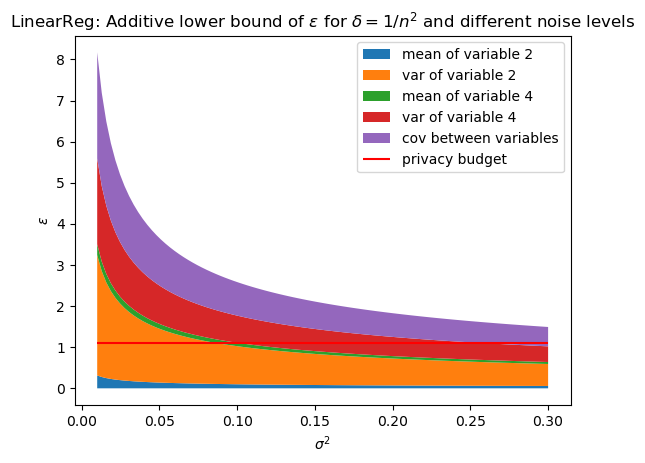

In [309]:
plt.figure()
plt.fill_between(noise_levels, np.zeros(epsilons_mean.shape[1]), epsilons_plot_sum[0],
                     label=f'mean of variable {subset[0]+1}')
plt.fill_between(noise_levels, epsilons_plot_sum[0], epsilons_plot_sum[1],
                     label=f'var of variable {subset[0]+1}')
plt.fill_between(noise_levels, epsilons_plot_sum[1], epsilons_plot_sum[2],
                     label=f'mean of variable {subset[1]+1}')
plt.fill_between(noise_levels, epsilons_plot_sum[2], epsilons_plot_sum[3],
                     label=f'var of variable {subset[1]+1}')
plt.fill_between(noise_levels, epsilons_plot_sum[3], epsilons_plot_sum[4], label='cov between variables')

plt.hlines(y=np.log(3), xmin=noise_levels[0], xmax=noise_levels[-1], color='red', label='privacy budget')

plt.ylabel('$\epsilon$')
plt.xlabel('$\sigma^2$')
plt.title(f'LinearReg: Additive lower bound of $\epsilon$ for $\delta=1/n^2$ and different noise levels')
plt.legend()
#plt.yscale('log')
#plt.savefig('plots/budget_linear_reg.png')
plt.show()

### Privacy Budget Consumption for Calculating all Covariances

In [285]:
n_operations = 1  # just computing this one covariance

In [286]:
epsilons_cov = np.zeros((10, len(noise_levels)))
cov_names = []
l = 0
for k, X_jk in enumerate(df_metric.values.T):
    print('\nvariable ', k+1)
    for k2, X_jk2 in enumerate(df_metric.values.T[k+1:,]):
        print('--variable ', k2+k+2)
        non_nans = ~np.isnan(X_jk)*~np.isnan(X_jk2)
        X_jk_reduced = X_jk[non_nans]
        X_jk2_reduced = X_jk2[non_nans]

        S_f_2_cov = get_sensitivity_cov(X_jk_reduced, X_jk2_reduced)
        for i, nl in enumerate(noise_levels):
            temp = get_epsilon(min_delta / n_operations, nl, S_f_2_cov)
            epsilons_cov[l, i] += temp
        # append name to list for plot
        cov_names.append(f'$cov({k+1},{k2+k+2})$')
        l += 1


variable  1
--variable  2
--variable  3
--variable  4
--variable  5

variable  2
--variable  3
--variable  4
--variable  5

variable  3
--variable  4
--variable  5

variable  4
--variable  5

variable  5


In [288]:
#df_epsilons_cov = pd.DataFrame(epsilons_cov, index=cov_names, columns=noise_levels)
#df_epsilons_cov.to_csv('epsilons_cov.csv')

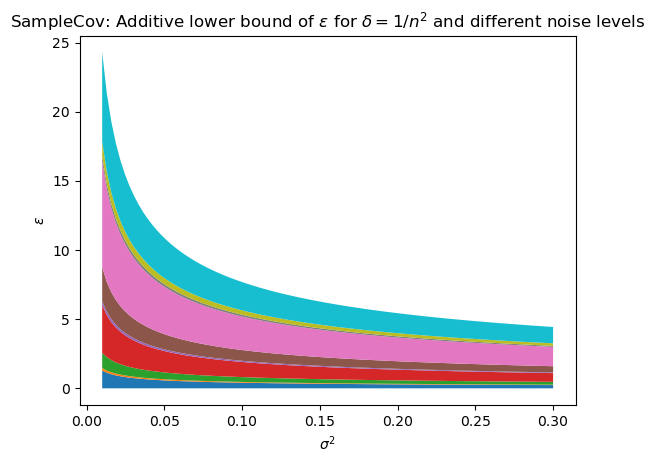

In [289]:
plt.figure()
epsilons_cov_sum = np.zeros(epsilons_cov.shape[1])
for l in range(10):
    plt.fill_between(noise_levels, epsilons_cov_sum, epsilons_cov_sum+epsilons_cov[l])
    epsilons_cov_sum += epsilons_cov[l]

plt.ylabel('$\epsilon$')
plt.xlabel('$\sigma^2$')
plt.title(f'SampleCov: Additive lower bound of $\epsilon$ for $\delta=1/n^2$ and different noise levels')
#plt.legend()
#plt.yscale('log')
#plt.savefig('plots/budget_cov.png')
plt.show()

In [297]:
# create heatmap, if epsilon is larger than log(3) make field red, otherwise green
epsilons_cov_heatmap = epsilons_cov.copy()
epsilons_cov_heatmap[epsilons_cov_heatmap > np.log(3)] = np.log(3)
epsilons_cov_heatmap = -epsilons_cov_heatmap / np.log(3)

In [298]:
noise_labels = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3]

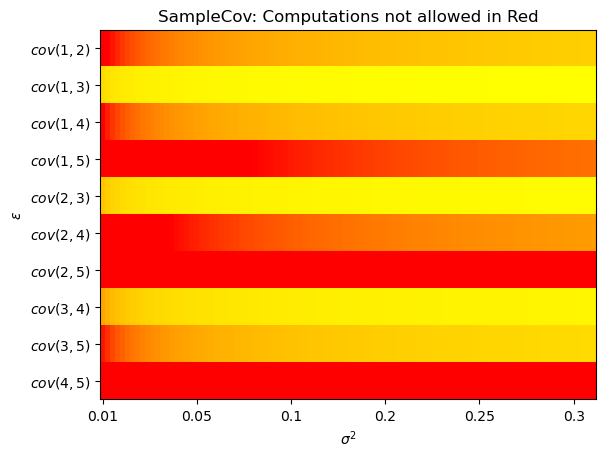

In [303]:
fig, ax = plt.subplots()

left = noise_levels[0]
right =  noise_levels[-1]
bottom = noise_levels[0]
top = noise_levels[-1]
extent = [left, right, bottom, top]

ax.imshow(epsilons_cov_heatmap, cmap='autumn', interpolation='none', aspect='auto')
#ax.grid(True)
ax.set_ylabel('$\epsilon$')
ax.set_xlabel('$\sigma^2$')
ax.set_title(f'SampleCov: Computations not allowed in Red')
ax.set_yticks(range(10))
ax.set_yticklabels(cov_names)
ax.set_xticks([i*19 for i in range(len(noise_labels))])
ax.set_xticklabels(noise_labels)
#plt.savefig('plots/budget_cov_heatmap.png')
plt.show()

### Further budget consumption plots

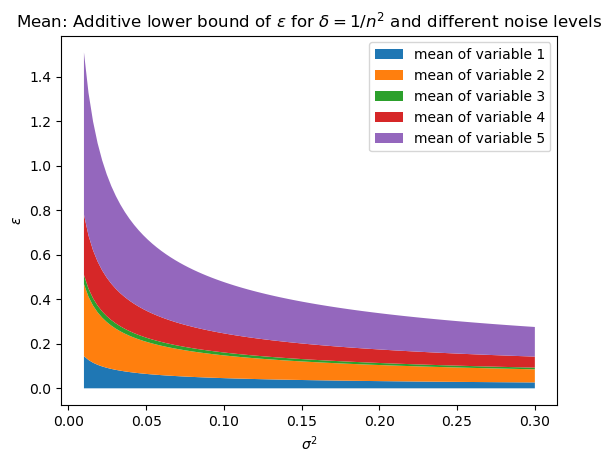

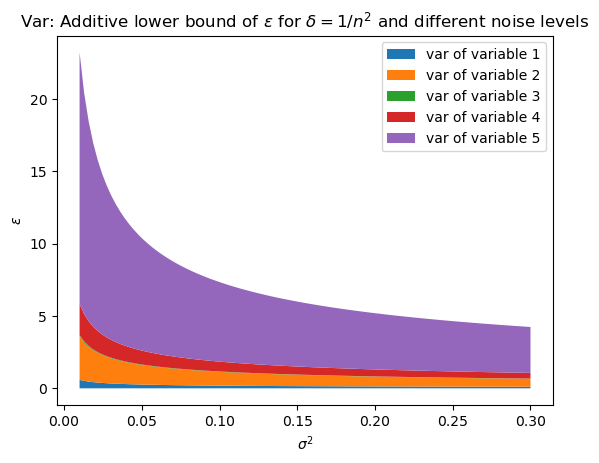

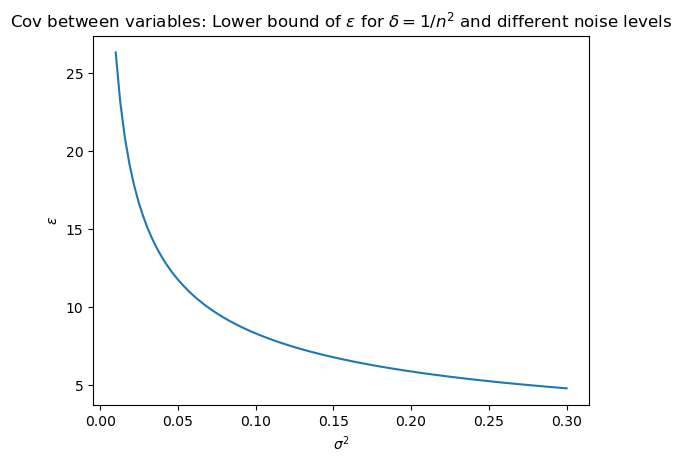

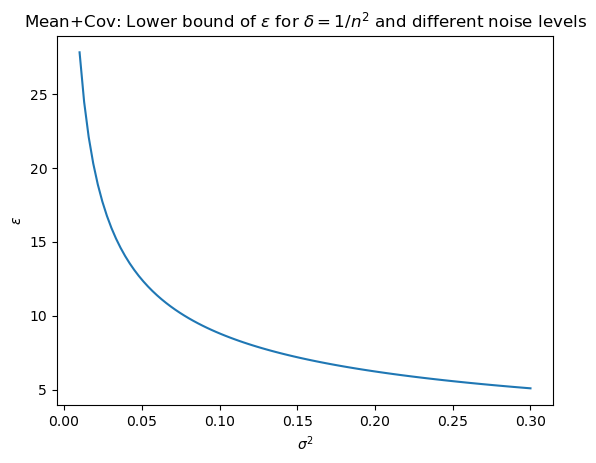

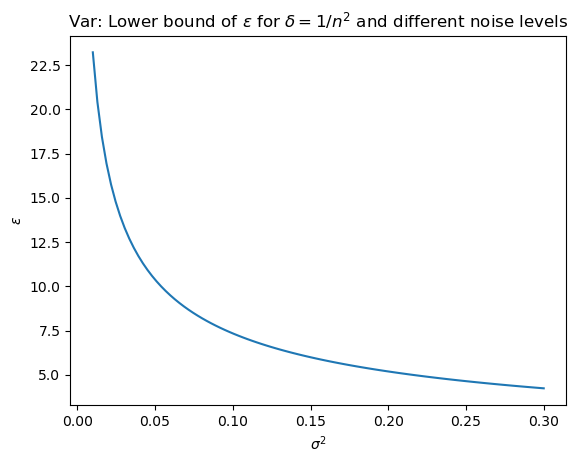

In [100]:
plt.figure()
epsilons_mean_sum = np.zeros(epsilons_mean.shape[1])
for i in range(n_vars):
    plt.fill_between(noise_levels, epsilons_mean_sum, epsilons_mean_sum+epsilons_mean[i],
                    label=f'mean of variable {i+1}')
    epsilons_mean_sum += epsilons_mean[i]

#plt.fill_between(noise_levels, epsilons_mean_sum, epsilons_cov_reduced, label='cov betwenn variables')

plt.ylabel('$\epsilon$')
plt.xlabel('$\sigma^2$')
plt.title(f'Mean: Additive lower bound of $\epsilon$ for $\delta=1/n^2$ and different noise levels')
plt.legend()
#plt.yscale('log')
plt.show()

plt.figure()
epsilons_var_sum = np.zeros(epsilons_var.shape[1])
for i in range(n_vars):
    plt.fill_between(noise_levels, epsilons_var_sum, epsilons_var_sum+epsilons_var[i],
                    label=f'var of variable {i+1}')
    epsilons_var_sum += epsilons_var[i]

#plt.fill_between(noise_levels, epsilons_mean_sum, epsilons_cov_reduced, label='cov between variables')

plt.ylabel('$\epsilon$')
plt.xlabel('$\sigma^2$')
plt.title(f'Var: Additive lower bound of $\epsilon$ for $\delta=1/n^2$ and different noise levels')
plt.legend()
#plt.yscale('log')
plt.show()

fig, ax = plt.subplots()
#x_ticks = np.arange(0, len(noise_levels))
ax.plot(noise_levels, epsilons_cov_reduced)
ax.set_ylabel('$\epsilon$')
ax.set_xlabel('$\sigma^2$')
#ax.set_xticks(x_ticks)
#ax.set_xticklabels(noise_levels, rotation=60)
plt.title(f'Cov between variables: Lower bound of $\epsilon$ for $\delta=1/n^2$ and different noise levels')
#plt.legend()
#plt.yscale('log')
plt.show()

fig, ax = plt.subplots()
#x_ticks = np.arange(0, len(noise_levels))
ax.plot(noise_levels, epsilons)
ax.set_ylabel('$\epsilon$')
ax.set_xlabel('$\sigma^2$')
#ax.set_xticks(x_ticks)
#ax.set_xticklabels(noise_levels, rotation=60)
plt.title(f'Mean+Cov: Lower bound of $\epsilon$ for $\delta=1/n^2$ and different noise levels')
#plt.legend()
#plt.yscale('log')
plt.show()

fig, ax = plt.subplots()
#x_ticks = np.arange(0, len(noise_levels))
ax.plot(noise_levels, epsilons_var_reduced)
ax.set_ylabel('$\epsilon$')
ax.set_xlabel('$\sigma^2$')
#ax.set_xticks(x_ticks)
#ax.set_xticklabels(noise_levels, rotation=60)
plt.title(f'Var: Lower bound of $\epsilon$ for $\delta=1/n^2$ and different noise levels')
#plt.legend()
#plt.yscale('log')
plt.show()